# Testing time cunsumption for different GLM alogrithms  
## 1. Import data
### 1.1. Set parameters

In [11]:
import pandas as pd
import numpy as np
import patsy
import mne
import os
import glob
import re
import matplotlib.pyplot as plt

event = 'Auditory' # or 'Resp'
stat = 'zscore'  # or 'power'
fif_name = f'{event}_{stat}-epo.fif'
task_Tag ='Repeat' #or Yes_No
glm_fea = 'Acoustic'

if glm_fea == 'Lexical':
    feature_seleted = np.r_[0:2]
elif glm_fea == 'Acoustic':
    feature_seleted = np.r_[0,34:50]
elif glm_fea == 'Phonemic':
    feature_seleted = np.r_[0,2:34]

HOME = os.path.expanduser("~")
LAB_root = os.path.join(HOME, "Box", "CoganLab")
clean_root = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepDelay', 'BIDS', "derivatives", "clean")
stats_root = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepDelay', 'BIDS', "derivatives", "stats")

subjs = [name for name in os.listdir(stats_root) if
         os.path.isdir(os.path.join(stats_root, name)) and name.startswith('D')]
import warnings

subjs = [subj for subj in subjs if
         subj != 'D0107' and subj != 'D0042' and subj != 'D0115']  # actually there is a D0115 rep data, we just skip it because D0115 doesn't have a yes_no
if task_Tag == 'Yes_No':
    subjs = [subj for subj in subjs if subj != 'D0115']

warnings.warn(f"The following subjects are not included: D0107 D0042")

subjs=['D0055','D0063','D0066','D0071',"D0079","D0081",'D0096']

C:\Users\bl314\AppData\Local\Temp\ipykernel_2948\3783764360.py:37: UserWarning: The following subjects are not included: D0107 D0042
  warnings.warn(f"The following subjects are not included: D0107 D0042")


### 1.2. Loop to import data, and get feature matrix

In [12]:
# Test Multicollinearity
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(X_i):
    """
    Computes the Variance Inflation Factor (VIF) for each feature in the given matrix 
    to detect multicollinearity. Also, plots the correlation matrix as a heatmap.
    
    Parameters:
    X_i : numpy.ndarray
        Feature matrix where each column represents a feature.
    
    Returns:
    pd.DataFrame
        A DataFrame showing the VIF values for each feature.
    """
    
    # Ensure the input is a NumPy array
    if not isinstance(X_i, np.ndarray):
        raise ValueError("Input X_i must be a NumPy array")

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = [f"X{i}" for i in range(X_i.shape[1])]
    vif_data["VIF"] = [variance_inflation_factor(X_i, i) for i in range(X_i.shape[1])]

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(X_i, rowvar=False)  # Compute correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm", xticklabels=vif_data["Feature"], yticklabels=vif_data["Feature"],annot_kws={"size": 5})
    plt.title("Feature Correlation Matrix")
    plt.show()

    return vif_data

# Example usage:
# vif_results = check_multicollinearity(X_i)
# print(vif_results)


Now do patent D0055
Reading C:\Users\bl314\Box\CoganLab\BIDS-1.0_LexicalDecRepDelay\BIDS\derivatives\stats\D0055\Auditory_zscore-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2990.00 ms
        0 CTF compensation matrices available
Not setting metadata
320 matching events found
No baseline correction applied


C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


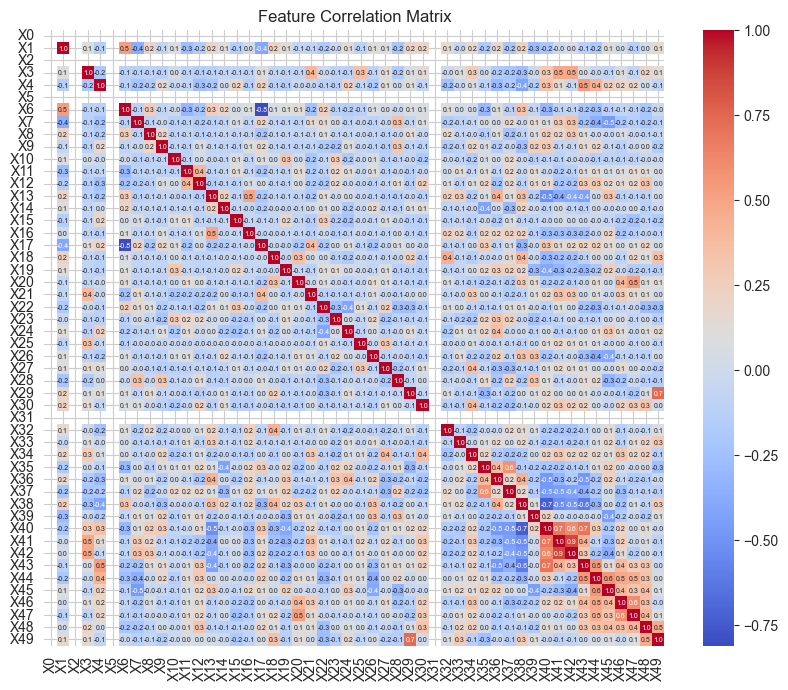

0     1218.416719
1        5.466163
2             NaN
3       27.038691
4       63.036668
5             NaN
6       73.839813
7       30.596220
8       21.437721
9        6.780841
10       4.285070
11      20.092956
12      37.408510
13      24.785397
14       2.837485
15       3.304956
16       3.461586
17      77.397206
18       9.870534
19      12.215257
20       5.767019
21       6.654160
22      12.252872
23       5.313706
24       4.961706
25       4.486742
26      17.123357
27       4.637448
28       6.648303
29      11.256262
30       6.018103
31            NaN
32       5.542982
33       4.762846
34       3.184191
35       6.981512
36       7.093877
37       8.139758
38      11.007275
39       4.942548
40      17.849687
41      14.656296
42      16.825988
43       9.525905
44       9.796794
45       8.206853
46       6.295431
47       5.179470
48       4.776016
49      14.404444
Name: VIF, dtype: float64
Now do patent D0063
Reading C:\Users\bl314\Box\CoganLab\BIDS-1.0_LexicalDe

In [14]:
# Read dictionaries for acoustic, phonemic, and the other stimulus-based feature matrix
import pandas as pd
phoneme_codes = pd.read_pickle("phoneme_one_hot_dict.pickle")
acoustic_codes = pd.read_pickle("envelope_feature_dict.pickle")

# %% start looping to load patients
data_list = []
filtered_events_list = []
chs = []

for i, subject in enumerate(subjs):
    print(f"Now do patent {subject}")

    #%% Load fif data
    subject_label_chs = 'D' + subject[1:].lstrip('0')
    subject = "sub-"+subject
    subject_No = subject.replace("sub-", "")
    subj_gamma_stats_dir = os.path.join(stats_root, subject_No)
    file_dir = os.path.join(subj_gamma_stats_dir, fif_name)
    epochs=mne.read_epochs(file_dir, False, preload=True)

    #%% Load events
    subj_gamma_clean_dir = os.path.join(clean_root, subject,'ieeg')
    files = glob.glob(os.path.join(subj_gamma_clean_dir, '*acq-*_run-*_desc-clean_events.tsv'))
    files_sorted = sorted(files, key=lambda x: [int(i) for i in re.findall(r'acq-(\d+)_run-(\d+)', x)[0]])
    dfs = [pd.read_csv(f, sep='\t') for f in files_sorted]
    events_df = pd.concat(dfs, ignore_index=True)
    filtered_events_i = events_df[events_df['trial_type'].str.contains(event)
                                & events_df['trial_type'].str.contains('CORRECT')
                                & events_df['trial_type'].str.contains(task_Tag)].reset_index(drop=True)
    trial_split = filtered_events_i['trial_type'].str.split('/', expand=True)
    trial_split.columns = ['Stage', 'RepYesNo', 'Wordness', 'Stim', 'Correctness']
    filtered_events_i = pd.concat([filtered_events_i, trial_split], axis=1)
    for col in ['Stage', 'RepYesNo', 'Wordness', 'Stim', 'Correctness']:
        filtered_events_i[col] = filtered_events_i[col].astype('category')

    if subject == 'sub-D0102' and task_Tag=='Repeat' and event == 'Auditory':
        filtered_events_i = filtered_events_i[:-1]
        
    # Get data
    if event=='Auditory':
        data_i = epochs[f'Auditory_stim/{task_Tag}/CORRECT'].get_data()
    elif event=='Resp':
        data_i = epochs[f'Resp/{task_Tag}/CORRECT'].get_data()
    if i == 0:
        times = epochs.times
    chs_i = epochs.ch_names
    chs_i = [f"{subject_label_chs}-{ch}" for ch in chs_i]

    # Feature matrix
    wordness_dummy = (filtered_events_i.Wordness == "Word").astype(float)
    phoneme_vectors = []
    acoustic_vectors = []
    for stim in filtered_events_i.Stim:
        phoneme_vectors.append(phoneme_codes[stim])
        acoustic_vectors.append(acoustic_codes[stim])
    X_i = np.column_stack([np.ones(np.shape(data_i)[0]), wordness_dummy,phoneme_vectors,acoustic_vectors])
    
    #Test Multicollinearity
    if i == 0:
        vif_data=check_multicollinearity(X_i)
        print(vif_data['VIF'])
        
    feature_mat_i = np.repeat(X_i[:, np.newaxis, :], np.shape(data_i)[1], axis=1)
    
    # store data
    data_list.append(data_i)
    filtered_events_list.append(feature_mat_i)
    chs.append(chs_i)


### 1.3. Generate a big data matrix (not used now, since permutation is done within single subjects)

In [ ]:
# # Calculate maximum number of trials and total channels
# max_trials = max(d.shape[0] for d in data_list)
# total_channels = sum(d.shape[1] for d in data_list)
# n_times = data_list[0].shape[2]  # Assume n_times is the same for all subjects
# 
# data = np.full((max_trials, total_channels, n_times), np.nan)
# feature_mat = np.full((max_trials, total_channels, 2), np.nan)
# channel_offset = 0
# for i, data_i in enumerate(data_list):
#     n_trials_i, n_channels_i, _ = data_i.shape
#     data[:n_trials_i, channel_offset:channel_offset + n_channels_i, :] = data_i
#     feature_mat_i = filtered_events_list[i]
#     feature_mat[:n_trials_i, channel_offset:channel_offset + n_channels_i, :] = feature_mat_i
#     channel_offset += n_channels_i
# 
# print("Data shape:", data.shape)
# print("Feature matrix shape:", feature_mat.shape)
# print("Total channels:", len(chs))

## 2. Compare model speed 
### 2.1. statsmodels OLS

In [ ]:
# import statsmodels.api as sm
# #from mne.stats import fdr_correction
# def sm_glm(x,y):
#     # x: observations (only one feature now)
#     # y: observations
#     # will get beta for one time point of the y: Y(t)=betas(t)X(t)+e
#     # return: beta
#     df = pd.DataFrame({'Y': y, 'X': x})
#     formula = 'Y ~ X'
#     Y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
#     model = sm.OLS(Y, X, missing='drop')
#     results = model.fit()
#     beta = results.params.iloc[1]
#     return beta

In [ ]:
# betas=[]
# for i, data_i in enumerate(data_list):
#     _, n_channels_i, n_times = data_i.shape
#     feature_mat_i = filtered_events_list[i]
#     beta_i = np.full((n_channels_i, n_times), np.nan)
#     for ch in range(n_channels_i):
#         print(f"patient {subjs[i]} chs {ch}")
#         for ti in range(n_times):
#             x = feature_mat_i[:, ch, 1]
#             y = data_i[:, ch, ti]
#             beta_i[ch,ti] = sm_glm(x,y)
#     betas.append(beta_i)
# betas_smols=np.concatenate(betas, axis=0)

### 2.2. Numpy's lstsq

In [15]:
def compute_r2_ch(x, y):
    # x: observations * features
    # y: observations * times
    # will get r2 for each time point of the y: Y(t)=betas(t)X(t)+e
    # return: r2: times
    mask = ~np.isnan(y[:,0])
    y_clean = y[mask,:]
    x_clean = x[mask,:]
    coef,resi = np.linalg.lstsq(x_clean, y_clean, rcond=None)[:2]
    residual = resi if resi.size>0 else np.sum((y_clean - x_clean @ coef) ** 2,axis=0)
    r2 = 1-residual/(np.sum((y_clean - np.mean(y_clean, axis=0)) ** 2, axis=0))
    return r2

def compute_r2_loop(feature_mat_i,data_i):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    # return r2_i: r2 matrix, channels * times
    _, n_channels_i, n_times = data_i.shape
    r2_i = np.full((n_channels_i, n_times), np.nan)
    for ch in range(n_channels_i):
        x = feature_mat_i[:, ch, :]
        y = data_i[:, ch, :]
        r2_i[ch,:] = compute_r2_ch(x,y)
    return r2_i

In [5]:
for i, data_i in enumerate(data_list):
    r2s=[]
    print(f"Patient {subjs[i]}")
    feature_mat_i = filtered_events_list[i][:,:,feature_seleted]
    compute_r2_loop_i = lambda data: compute_r2_loop(feature_mat_i, data)
    r2_i = compute_r2_loop_i(data_i)
    r2s.append(r2_i)
    r2s=np.concatenate(r2s,axis=0)
    plot_r2(r2s,f'patient{subjs[i]}','r2')

Patient D0055


NameError: name 'plot_r2' is not defined

### 2.3. Compare results (statsmodels OLS is set as standard)

In [16]:
   # Plot GLM
def plot_r2(data_in,title,colbar_lab):
    
    plt.figure(figsize=(10, 5))
    plt.imshow(data_in, aspect='auto', cmap='gray_r', interpolation='nearest')#, vmin=-0.5e-5, vmax=0.5e-5)
    plt.colorbar(label=colbar_lab)
    plt.xlabel("Time points")
    plt.ylabel("Channels")
    plt.title(title)
    
    xticks = np.arange(0, len(times), 20)
    plt.xticks(ticks=xticks, labels=np.round(times[xticks], 2))
    plt.xlabel("Time (s)")
    # 
    # yticks = np.arange(0, len(chs), 5)
    # plt.yticks(ticks=yticks, labels=[chs[i] for i in yticks])
    plt.ylabel("Channels")
    
    zero_time_index = np.argmin(np.abs(times - 0))
    plt.axvline(x=zero_time_index, color='red', linestyle='--', linewidth=1.5, label="Time = 0")
    
    plt.show()

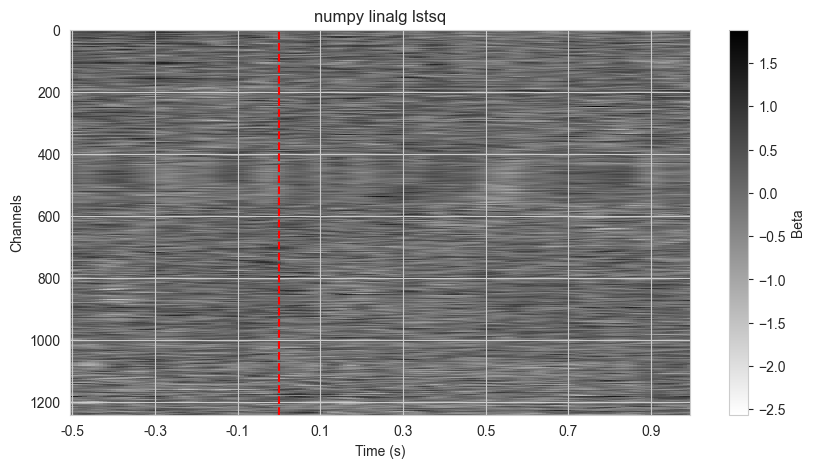

NameError: name 'betas_smols' is not defined

In [8]:
plot_r2(r2s_lstsq,'numpy linalg lstsq','r2')
plot_r2(r2s_smols,'numpy statsmodel ols','r2')

## 3. Try permutation
### 3.1. Used Scipy's permutation_test function
#### 3.1.1. The adjusted stats function

In [22]:
def compute_beta_ch_for_perm(x, y):
    # x: observations (features in nested list)
    # y: observations
    # will get beta for each time point of the y: Y(t)=betas(t)X(t)+e
    # return: R^2
    x = np.array(x.tolist())
    y = y.astype(float)
    mask = ~np.isnan(y)
    y_clean = y[mask]
    x_clean = x[mask,:]
    beta = np.linalg.lstsq(x_clean, y_clean, rcond=None)[0]
    # y_pred = x_clean @ beta 
    # r2 = 1 - np.sum((y_clean - y_pred) ** 2) / (len(y_clean) * np.var(y_clean, ddof=0))
    return beta[1]

#### 3.1.2. Run permutation

In [ ]:
from scipy.stats import permutation_test
ress=[]
for i, data_i in enumerate(data_list):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    print(f"Patient {subjs[i]}")
    feature_mat_i = filtered_events_list[i][:,:,0:2]
    feature_mat_i_nested = np.empty(feature_mat_i.shape[:2], dtype=object)
    for m in range(feature_mat_i.shape[0]):
        for j in range(feature_mat_i.shape[1]):
            feature_mat_i_nested[m, j] = list(feature_mat_i[m, j])
    feature_mat_i_expanded = np.repeat(feature_mat_i_nested[:, :, np.newaxis], data_i.shape[2], axis=2)
    print(feature_mat_i_expanded.shape)
    print(data_i.shape)
    res=permutation_test([feature_mat_i_expanded,data_i], compute_beta_ch_for_perm, permutation_type='pairings',n_resamples=10,alternative='two-sided', axis=0)
    ress.append(res)

### 3.2. Baishen's own parallel permutation function
#### 3.2.1. The permutation function

In [17]:
# Baishen's Parallel
from joblib import Parallel, delayed

def permutation_baishen_parallel(feature_mat_i, data_i, n_perms):
    
    n_obs = feature_mat_i.shape[0]
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times    
    def worker(_):
        perm_indices = np.random.permutation(n_obs)
        perm_feature_mat = feature_mat_i[perm_indices, :, :]
        r2_i = compute_r2_loop(perm_feature_mat, data_i)
        return r2_i
    
    results = Parallel(n_jobs=-5)(delayed(worker)(k) for k in range(n_perms))
    null_r2 = np.stack(results, axis=0)  # shape: (n_perms, channels, times)
    return null_r2

#### 3.2.2. Run permutation and save the null distribution

In [18]:
for i, data_i in enumerate(data_list):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    print(f"Patient {subjs[i]}")
    feature_mat_i = filtered_events_list[i][:,:,feature_seleted]
    n_perms = 10000
    null_r2 = permutation_baishen_parallel(feature_mat_i, data_i, n_perms)
    np.save(f'null_r2 {subjs[i]} {event} {task_Tag} {glm_fea}.npy', null_r2)
    del null_r2

Patient D0055
Patient D0063
Patient D0066
Patient D0071
Patient D0079
Patient D0081
Patient D0096


#### 3.2.3. Get permutation masks for each patient

In [19]:
#https://ieeg-pipelines.readthedocs.io/en/latest/_modules/ieeg/calc/stats.html#time_perm_cluster
#_perm_gt_1d
def aaron_perm_gt_1d(diff, axis=0):
    m = diff.shape[axis] - 1
    sorted_indices = diff.argsort(axis=axis)  # Get sorted indices
    proportions = np.arange(diff.shape[axis]) / m  # Create proportions array
    # Rearrange to match original order
    return proportions[sorted_indices.argsort(axis=axis)]

In [20]:
# Compute p values upon null distribution
alpha=0.05
for i, _ in enumerate(subjs):    
    print(f"Patient {subjs[i]}")
    # shape: (n_perms, channels, times)
    null_r2_i = np.load(f"null_r2 {subjs[i]} {event} {task_Tag} {glm_fea}.npy")
    # Get the significancy for each permutation that is with **Larger** r2s than null distribution
    null_significance_masks=(aaron_perm_gt_1d(null_r2_i, axis=0)>(1-alpha)).astype(int)
    np.save(f'null_mask {subjs[i]} {event} {task_Tag} {glm_fea}.npy', null_significance_masks)
    del null_significance_masks
    del null_r2_i

Patient D0055
Patient D0063
Patient D0066
Patient D0071
Patient D0079
Patient D0081
Patient D0096


#### 3.2.4. Run time-cluster correction

Patient D0055
run time cluster


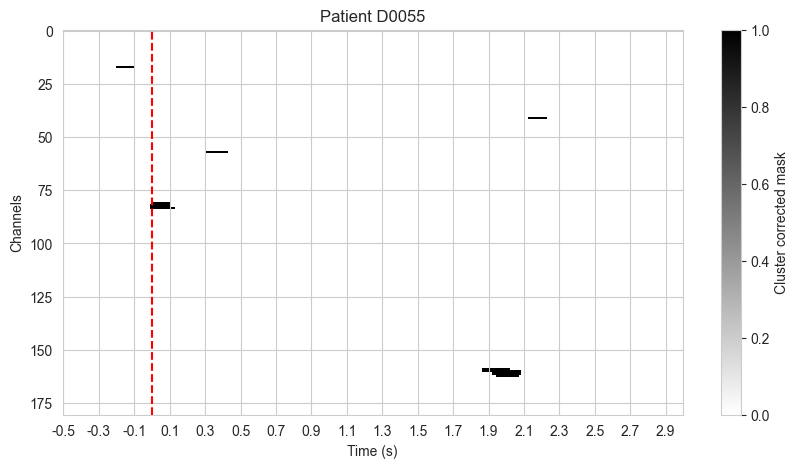

Patient D0063
run time cluster


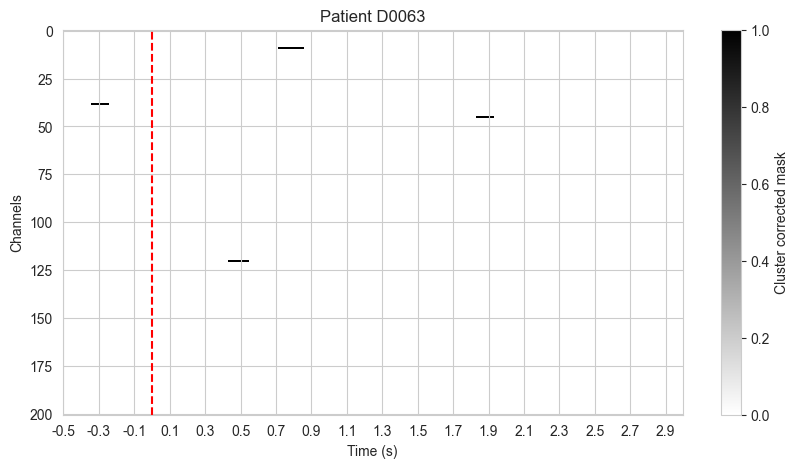

Patient D0066
run time cluster


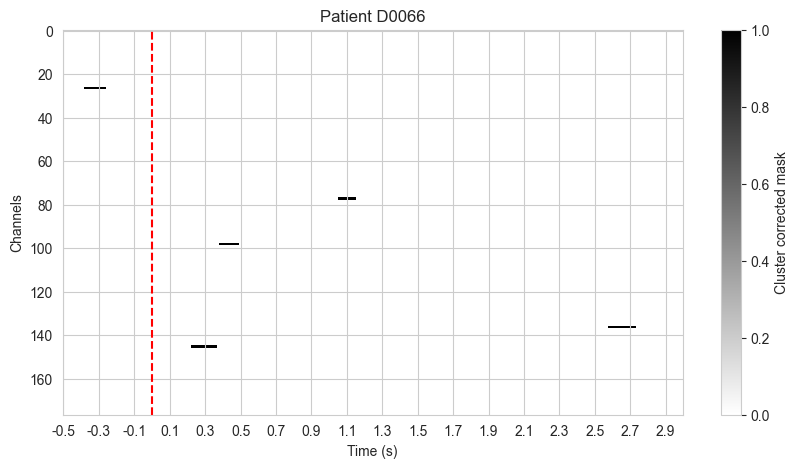

Patient D0071
run time cluster


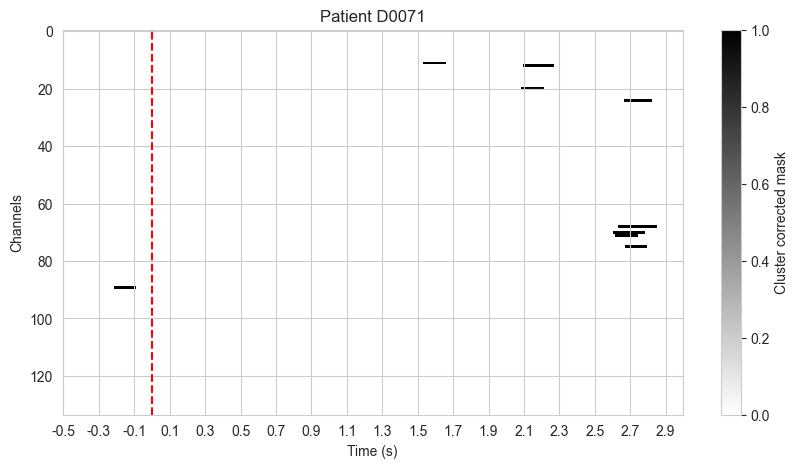

Patient D0079
run time cluster


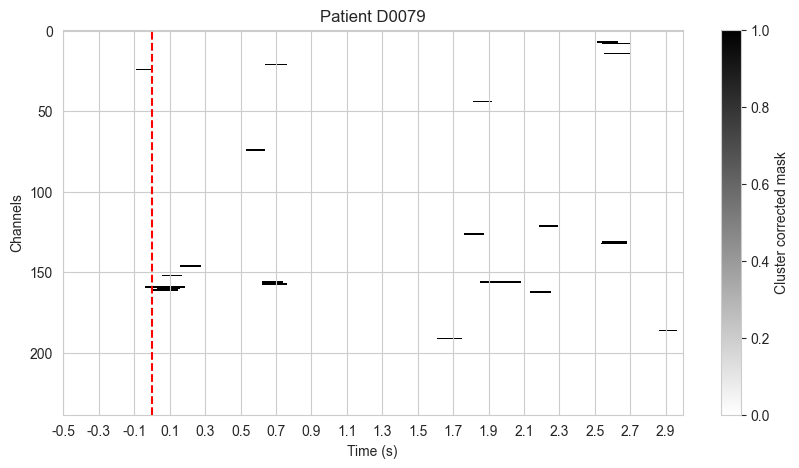

Patient D0081
run time cluster


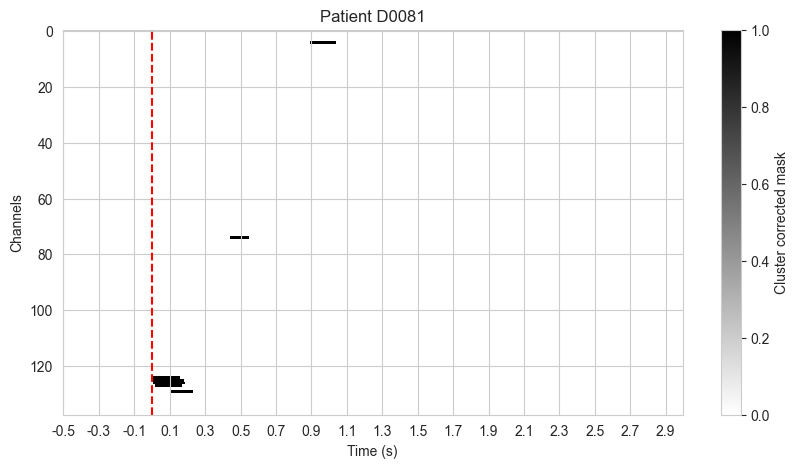

Patient D0096
run time cluster


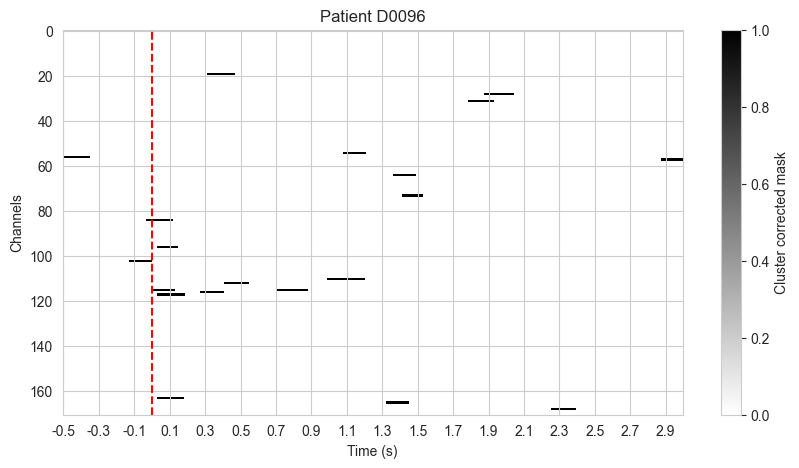

In [21]:
alpha=0.05
alpha_clus=0.05
from ieeg.calc.stats import time_cluster
for i, data_i in enumerate(data_list):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    # r2_i: r2 matrix, channels * features * times
    print(f"Patient {subjs[i]}")
    
    # combine original and permute r2
    feature_mat_i = filtered_events_list[i][:,:,feature_seleted]
    r2_i=compute_r2_loop(feature_mat_i,data_i)
    null_r2_i = np.load(f"null_r2 {subjs[i]} {event} {task_Tag} {glm_fea}.npy")
    r2_i = np.expand_dims(r2_i, axis=0)
    np.save(f"r2 {subjs[i]} {event} {task_Tag} {glm_fea}.npy", r2_i)
    r2s_i = np.concatenate([r2_i, null_r2_i], axis=0)
    del r2_i, null_r2_i
    
    # get significance of the original r2 against the permutation distribution
    # return: mask_left_i_org channels*times
    org_p_i=aaron_perm_gt_1d(r2s_i, axis=0)[0]
    mask_i_org=(org_p_i>(1-alpha)).astype(int)
    del r2s_i
    
    # run time cluster correction
    mask_null_i=np.load(f"null_mask {subjs[i]} {event} {task_Tag} {glm_fea}.npy")
    mask_time_clus=np.full([mask_i_org.shape[0],mask_i_org.shape[1]],np.nan)
    print('run time cluster')
    # The output p_time_clus tells how **LARGER** the clusters in the real mask are as compared with the clusters in the permuted masks
    # The larger the values, the higher the probabilities are
    for chs in range(mask_i_org.shape[0]):
        mask_time_clus[chs,:]=time_cluster(mask_i_org[chs,:], mask_null_i[:,chs,:],1-alpha_clus)
    del mask_i_org,mask_null_i
    np.save(f"Time_cluster_mask {subjs[i]} {event} {task_Tag} {glm_fea}.npy", mask_time_clus)
    
    # Plot
    plot_r2(mask_time_clus,f"Patient {subjs[i]}","Cluster corrected mask")


    